## Latency vs. number of robots (LIBERO)

This notebook scans the LIBERO benchmark folders under:

- `/srv/rl2-lab/flash8/rbansal66/vvla/openpi/data/libero`

and produces a **latency vs. number of robots** plot comparing:

- **non-realtime**: `batch_1_robots_{N}`
- **realtime**: `batch_1_robots_{N}_realtime`

Notes:
- `ActionChunk.latency` in `examples/libero/schemas.py` is **in seconds**; plots below convert to **milliseconds** (ms).



In [1]:
from __future__ import annotations

import re
import sys
from pathlib import Path
from typing import Dict, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p / "examples" / "libero" / "schemas.py").exists():
            return p
    return start


PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from examples.libero.schemas import ActionChunk  # noqa: E402

DATA_ROOT = Path("/srv/rl2-lab/flash8/rbansal66/vvla/openpi/data/libero")
assert DATA_ROOT.exists(), f"Missing data root: {DATA_ROOT}"

BATCH_DIR_RE = re.compile(r"^batch_(?P<batch>\d+)_robots_(?P<num_robots>\d+)(?P<realtime>_realtime)?$")


def iter_batch_dirs(data_root: Path, *, batch: Optional[int] = 1) -> Iterator[Tuple[int, str, Path]]:
    """Yield (num_robots, mode, path) for matching batch folders."""
    for p in sorted(data_root.iterdir()):
        if not p.is_dir():
            continue
        m = BATCH_DIR_RE.match(p.name)
        if not m:
            continue

        batch_id = int(m.group("batch"))
        if batch is not None and batch_id != batch:
            continue

        num_robots = int(m.group("num_robots"))
        mode = "realtime" if m.group("realtime") else "non_realtime"
        yield num_robots, mode, p


def load_latencies_ms(batch_dir: Path) -> Tuple[np.ndarray, int]:
    """Return (latencies_ms, n_runs) from all `*/*/action_chunks.csv` in a batch dir."""
    action_chunk_csvs = sorted(batch_dir.glob("*/*/action_chunks.csv"))

    lat_s: List[float] = []
    for csv_path in action_chunk_csvs:
        chunks = ActionChunk.from_csv(csv_path)
        lat_s.extend([c.latency for c in chunks])

    lat_ms = np.asarray(lat_s, dtype=np.float64) * 1000.0
    return lat_ms, len(action_chunk_csvs)


def summarize_latencies(lat_ms: np.ndarray) -> dict:
    if lat_ms.size == 0:
        return {
            "n_chunks": 0,
            "mean_ms": np.nan,
            "p50_ms": np.nan,
            "p90_ms": np.nan,
            "p95_ms": np.nan,
            "p99_ms": np.nan,
        }

    return {
        "n_chunks": int(lat_ms.size),
        "mean_ms": float(np.mean(lat_ms)),
        "p50_ms": float(np.percentile(lat_ms, 50)),
        "p90_ms": float(np.percentile(lat_ms, 90)),
        "p95_ms": float(np.percentile(lat_ms, 95)),
        "p99_ms": float(np.percentile(lat_ms, 99)),
    }



In [2]:
rows = []

for num_robots, mode, batch_dir in iter_batch_dirs(DATA_ROOT, batch=1):
    lat_ms, n_runs = load_latencies_ms(batch_dir)
    stats = summarize_latencies(lat_ms)

    rows.append(
        {
            "num_robots": num_robots,
            "mode": mode,
            "n_runs": int(n_runs),
            **stats,
        }
    )

latency_df = pd.DataFrame(rows).sort_values(["num_robots", "mode"]).reset_index(drop=True)
latency_df


,num_robots,mode,n_runs,n_chunks,mean_ms,p50_ms,p90_ms,p95_ms,p99_ms
0,1,non_realtime,10,91,148.160782,147.683382,148.875237,149.693966,157.336760
1,1,realtime,10,94,91.266158,92.490673,95.772862,97.003567,97.436900
2,2,non_realtime,20,184,154.192590,147.540212,159.851456,194.794416,264.163256
3,2,realtime,20,188,89.122673,87.958217,96.215558,97.461200,145.006042
4,3,non_realtime,30,272,148.995057,147.339582,148.698068,151.102233,240.722241
5,3,realtime,30,268,89.242540,87.741494,96.871638,97.405159,149.617336
6,5,non_realtime,50,455,151.369370,146.785021,151.432514,164.867568,262.119699
7,5,realtime,50,469,44.933888,45.845032,47.229385,47.304344,62.085505
8,10,non_realtime,100,911,180.394089,148.475170,261.543751,293.696761,419.661522
9,10,realtime,100,904,89.496101,81.061006,116.514564,143.358326,181.127751


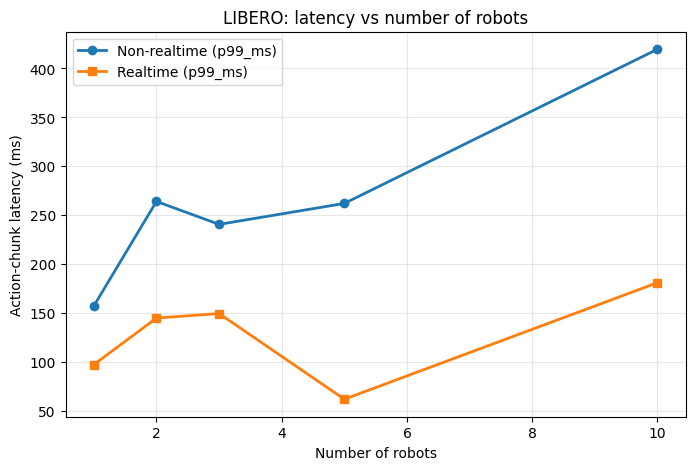

In [3]:
def plot_latency_vs_robots(df: pd.DataFrame, *, metric: str = "p99_ms"):
    fig, ax = plt.subplots(figsize=(8, 5))

    styles = {
        "non_realtime": {"color": "C0", "marker": "o", "label": "Non-realtime"},
        "realtime": {"color": "C1", "marker": "s", "label": "Realtime"},
    }

    for mode, style in styles.items():
        sub = df[df["mode"] == mode].sort_values("num_robots")
        if sub.empty:
            continue

        ax.plot(
            sub["num_robots"],
            sub[metric],
            marker=style["marker"],
            linewidth=2,
            color=style["color"],
            label=f"{style['label']} ({metric})",
        )

    ax.set_xlabel("Number of robots")
    ax.set_ylabel("Action-chunk latency (ms)")
    ax.set_title("LIBERO: latency vs number of robots")
    ax.grid(True, alpha=0.3)
    ax.legend()

    return fig, ax


fig, ax = plot_latency_vs_robots(latency_df, metric="p99_ms")
plt.show()


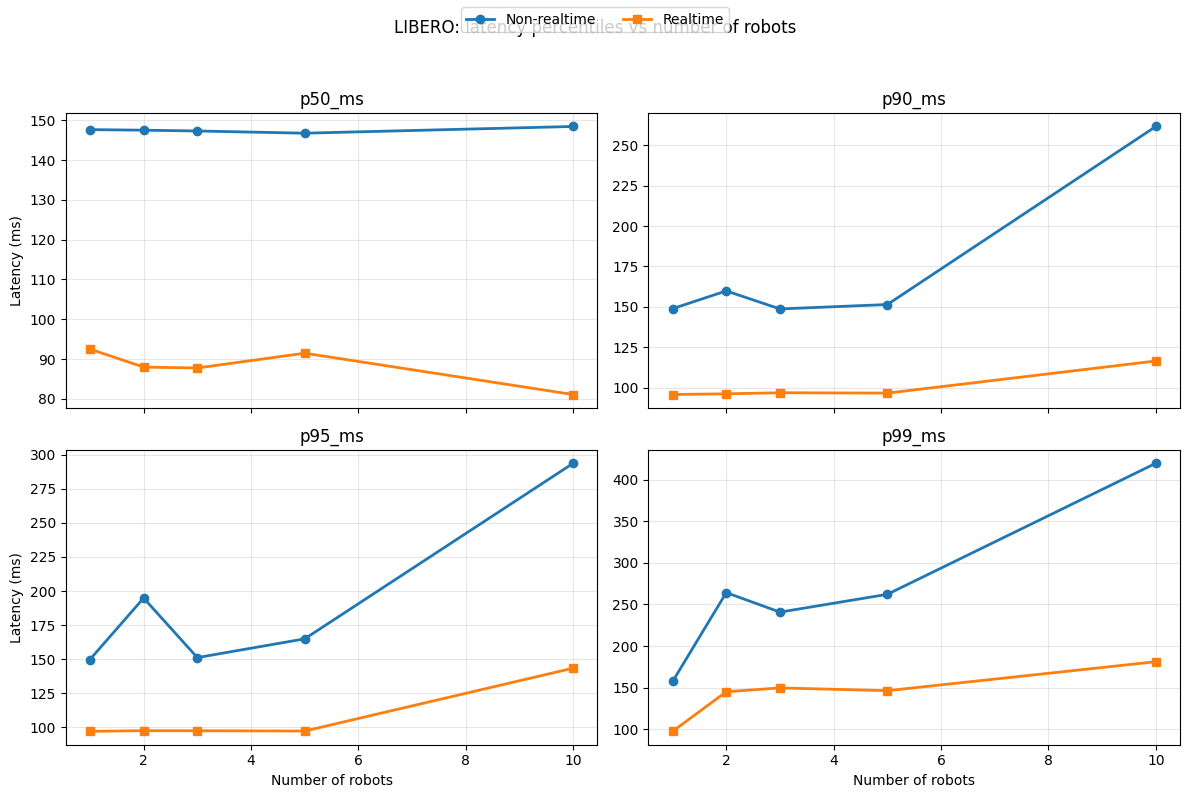

In [4]:
# Optional: compare multiple percentiles at once
metrics = ["p50_ms", "p90_ms", "p95_ms", "p99_ms"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for mode, style in {
        "non_realtime": {"color": "C0", "marker": "o", "label": "Non-realtime"},
        "realtime": {"color": "C1", "marker": "s", "label": "Realtime"},
    }.items():
        sub = latency_df[latency_df["mode"] == mode].sort_values("num_robots")
        if sub.empty:
            continue
        ax.plot(sub["num_robots"], sub[metric], color=style["color"], marker=style["marker"], linewidth=2, label=style["label"])

    ax.set_title(metric)
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel("Number of robots")
axes[3].set_xlabel("Number of robots")
axes[0].set_ylabel("Latency (ms)")
axes[2].set_ylabel("Latency (ms)")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
fig.suptitle("LIBERO: latency percentiles vs number of robots", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
